In [25]:
# 638 Deep Learning Final Project: Pokedex

Import required packages

In [1]:
import os
import shutil
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fcos_resnet50_fpn
from torchvision.models.detection import retinanet_resnet50_fpn

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu117
Torchvision Version:  0.15.1+cu117


**1. Classification**

Function for splitting data into train and validation sets

Notice: You do not need to run this part yourself. You can load our pretrained model and directly use it. If you want to test this part, please create two empty folders manually. Remember that this part can only be ran once, multiple running will create redundant files in the validation folder.

In [4]:
# Split data into training and validation sets
def split_data(src, train_dst, val_dst, val_ratio=0.2):
    if not os.path.exists(train_dst):
        os.makedirs(train_dst)
    if not os.path.exists(val_dst):
        os.makedirs(val_dst)

    classes = sorted(os.listdir(src))

    for cls in classes:
        src_cls = os.path.join(src, cls)
        train_cls = os.path.join(train_dst, cls)
        val_cls = os.path.join(val_dst, cls)

        if not os.path.exists(train_cls):
            os.makedirs(train_cls)
        if not os.path.exists(val_cls):
            os.makedirs(val_cls)

        images = os.listdir(src_cls)
        random.shuffle(images)

        split_idx = int(len(images) * (1 - val_ratio))
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        for img in train_images:
            shutil.copy(os.path.join(src_cls, img), os.path.join(train_cls, img))
        for img in val_images:
            shutil.copy(os.path.join(src_cls, img), os.path.join(val_cls, img))

src_data = "./PokemonData/"
train_data_dir = "./Train"
val_data_dir = "./Validation"

split_data(src_data, train_data_dir, val_data_dir)

Define Pokemon classes from the dataset

In [2]:
# Custom dataset class
class PokemonDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(root))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []

        for cls in self.classes:
            cls_path = os.path.join(root, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.images.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

Define data transformation required to feed the data to ResNet50

In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Load datasets and split into train and validation sets

In [4]:
# Load the datasets
train_data = PokemonDataset("C:\\Users\\26392\\Desktop\\638\\Pokemon\\train", transform=transform)
val_data = PokemonDataset("C:\\Users\\26392\\Desktop\\638\\Pokemon\\val", transform=transform)

Define dataloaders

In [5]:
# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Define ResNet50 model with pretrained parameters

In [6]:
# Load a pre-trained model (ResNet)
model = models.resnet50(pretrained=True)

C:\Users\26392\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\26392\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modify last layer of the classifier according to the number of classes

In [7]:
# Modify the last layer to match the number of classes
num_features = model.fc.in_features
num_classes = len(train_data.classes)
model.fc = torch.nn.Linear(num_features, num_classes)

Move to GPU if available

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define ResNet50 loss function (cross entropy) and optimizer (SGD)

In [9]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model for 20 epochs and batch size of 32 and validate

Notice: You do not need to train the model yourself, you can directly load and use our pretrained model.

In [21]:
# Train the model
num_epochs = 20
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Print progress
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "pokemon_classifier_best.pth")


Epoch [1/20], Step [10/169], Loss: 4.9941
Epoch [1/20], Step [20/169], Loss: 4.9540
Epoch [1/20], Step [30/169], Loss: 4.8665
Epoch [1/20], Step [40/169], Loss: 4.8696
Epoch [1/20], Step [50/169], Loss: 4.8914
Epoch [1/20], Step [60/169], Loss: 4.8127
Epoch [1/20], Step [70/169], Loss: 4.7549
Epoch [1/20], Step [80/169], Loss: 4.6391
Epoch [1/20], Step [90/169], Loss: 4.7269
Epoch [1/20], Step [100/169], Loss: 4.6319
Epoch [1/20], Step [110/169], Loss: 4.4331
Epoch [1/20], Step [120/169], Loss: 4.4758
Epoch [1/20], Step [130/169], Loss: 4.3255
Epoch [1/20], Step [140/169], Loss: 4.2169
Epoch [1/20], Step [150/169], Loss: 4.2833
Epoch [1/20], Step [160/169], Loss: 4.0087
Epoch [1/20], Validation Accuracy: 0.4116
Epoch [2/20], Step [10/169], Loss: 3.6514
Epoch [2/20], Step [20/169], Loss: 3.5152
Epoch [2/20], Step [30/169], Loss: 3.4492
Epoch [2/20], Step [40/169], Loss: 3.6541
Epoch [2/20], Step [50/169], Loss: 3.4783
Epoch [2/20], Step [60/169], Loss: 3.3201
Epoch [2/20], Step [70/169]

Define the predict function for testing to return the predicted class and confidence score

In [10]:
def predict(image_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, max_idx = torch.max(probabilities, dim=1)

    predicted_class = class_names[max_idx.item()]
    confidence = max_prob.item()

    return predicted_class, confidence

Load the best model saved through training

Here is the part you load our pretrained model and play with some test images. The classifier along only takes single Pokemon pictures.

In [11]:
# Load the saved model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = "pokemon_classifier_best.pth"
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
num_classes = 150  # Change this to the number of classes in your dataset
model.fc = torch.nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)

# Load the class names
train_data_dir = "./Train"
class_names = sorted(os.listdir(train_data_dir))

C:\Users\26392\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
test_image_path = "./test/test_scyther.jpg"
predicted_class, confidence = predict(test_image_path, model, class_names)
print(f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}")

Predicted class: Scyther, Confidence: 0.9910


Test with entire test folder and save results in a folder 

Not recommended to run this part since we add many mixed images into the test folder.

In [10]:
def predict_folder(folder_path, model, class_names):
    image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

    results = []
    for img_path in image_paths:
        predicted_class, confidence = predict(img_path, model, class_names)
        results.append((img_path, predicted_class, confidence))

    return results

In [22]:
# Test on multiple images in a folder
test_folder_path = "C:\\Users\\26392\\Desktop\\638\\Pokemon\\test"
results = predict_folder(test_folder_path, model, class_names)

# Print the results
for img_path, predicted_class, confidence in results:
    print(f"Image: {img_path}, Predicted class: {predicted_class}, Confidence: {confidence:.4f}")

Image: C:\Users\26392\Desktop\638\Pokemon\test\test_charzard.jpg, Predicted class: Charizard, Confidence: 0.9494
Image: C:\Users\26392\Desktop\638\Pokemon\test\test_gengar.jpg, Predicted class: Gengar, Confidence: 0.9757
Image: C:\Users\26392\Desktop\638\Pokemon\test\test_satoshi.jpg, Predicted class: Hitmonchan, Confidence: 0.1279
Image: C:\Users\26392\Desktop\638\Pokemon\test\test_scyther.jpg, Predicted class: Scyther, Confidence: 0.9910


**2. Object Detection and Segmentation**

In [14]:
def object_detection(image_path, model, threshold=0.0):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        detections = model(image_tensor)
    
    image_boxes = []
    for box, score in zip(detections[0]["boxes"], detections[0]["scores"]):
        if score > threshold:
            image_boxes.append(box)
    
    return image_boxes

Function to draw the bounding boxes

In [15]:
def draw_boxes(image_path, boxes, labels, confidences):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for box, label, conf in zip(boxes, labels, confidences):
        x1, y1, x2, y2 = map(int, box)  # Convert the box coordinates to integers
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        text = f"{label} ({conf:.2f})"
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

Classify the Pokemon in a given bounding box using the trained ResNet50 model

In [16]:
def predictbox(image, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = image.convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, max_idx = torch.max(probabilities, dim=1)

    predicted_class = class_names[max_idx.item()]
    confidence = max_prob.item()

    return predicted_class, confidence

Combine the segmentation results from FCOS, FasterRCNN, and RetinaNet

In [17]:
# Load Segmentation Models
object_detection_model = fcos_resnet50_fpn(pretrained=True)
object_detection_model.to(device)
object_detection_model.eval()
object_detection_model2 = fasterrcnn_resnet50_fpn(pretrained=True)
object_detection_model2.to(device)
object_detection_model2.eval()
object_detection_model3 = retinanet_resnet50_fpn(pretrained=True)
object_detection_model3.to(device)
object_detection_model3.eval()

C:\Users\26392\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCOS_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FCOS_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\26392\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most u

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


Test on some images including multiple Pokemons

In [18]:
# Object detection
input_image_path = "./test/mix4.jpg"
bounding_boxes = object_detection(input_image_path, object_detection_model)


In [19]:
bounding_boxes2 = object_detection(input_image_path, object_detection_model2)
bounding_boxes3 = object_detection(input_image_path, object_detection_model3)
bounding_boxes = bounding_boxes + bounding_boxes2 + bounding_boxes3


In [20]:
# Predict the class and confidence for each bounding box
boxes, labels, confidences = [], [], []
for box in bounding_boxes:
    x1, y1, x2, y2 = map(int, box.tolist())
    cropped_image = Image.open(input_image_path).convert('RGB').crop((x1, y1, x2, y2))
    predicted_class, confidence = predictbox(cropped_image, model, class_names)
    boxes.append([x1, y1, x2, y2])
    labels.append(predicted_class)
    confidences.append(confidence)

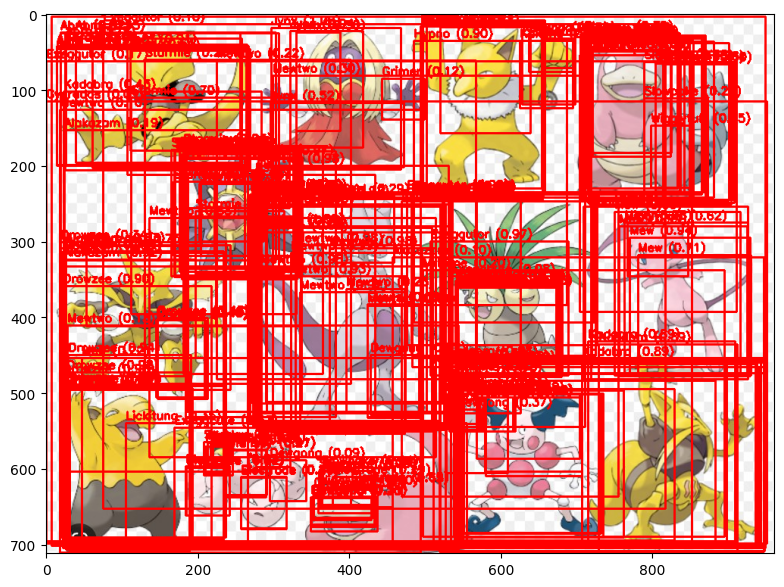

In [21]:
# Draw the bounding boxes
output_image = draw_boxes(input_image_path, boxes, labels, confidences)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.imshow(output_image)


Define confidence score threshold for special classes to prevent from wrong predictions

In [22]:
# Define the thresholds for special classes
special_thresholds = {
    "Metapod": 0.98,
    "Voltorb": 0.95,
    "Kabuto": 0.8,
    # Add more special classes here, e.g., "SpecialClass": 0.9,
}

filtered_boxes, filtered_labels, filtered_confidences = [], [], []

for box, label, conf in zip(boxes, labels, confidences):
    threshold = special_thresholds.get(label, 0.75)  # Default threshold

    if conf > threshold:
        filtered_boxes.append(box)
        filtered_labels.append(label)
        filtered_confidences.append(conf)


Find the bounding box with maximum confidence score for each class present in the image

In [23]:
# Find the maximum confidence box for each class

max_conf_per_class = {}
for i, conf in enumerate(filtered_confidences):
    label = filtered_labels[i]
    if label not in max_conf_per_class or conf > max_conf_per_class[label][0]:
        max_conf_per_class[label] = (conf, i)

# Extract the filtered boxes, labels, and confidences using the indices
max_indices = [val[1] for val in max_conf_per_class.values()]
max_boxes = [filtered_boxes[i] for i in max_indices]
max_labels = [filtered_labels[i] for i in max_indices]
max_confidences = [filtered_confidences[i] for i in max_indices]


Show a final test result

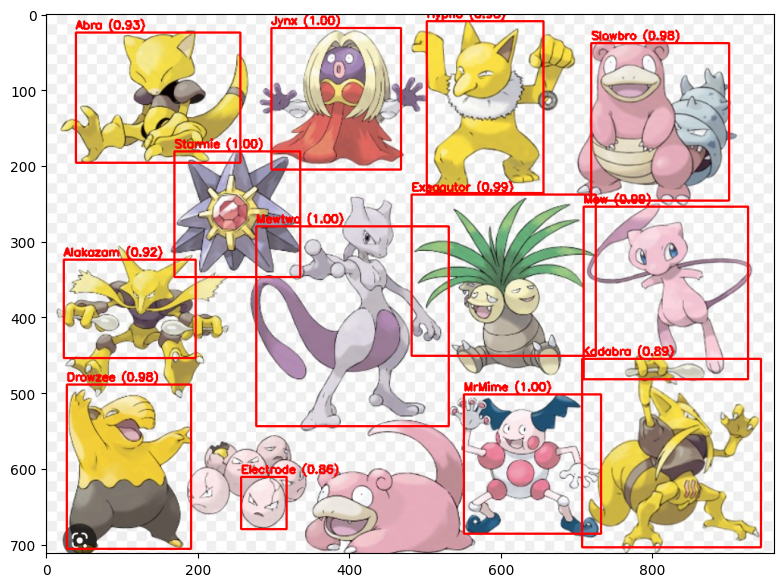

In [24]:
output_image = draw_boxes(input_image_path, max_boxes, max_labels, max_confidences)
plt.figure(figsize=(12,7))
plt.imshow(output_image)

Save the test result individually. You can skip if you don't want to save.

In [113]:
# Save the output image
output_image_path = "./test/testresults/mix4_result.jpg"
output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
cv2.imwrite(output_image_path, output_image)

True

Try Non-Maximum Supression 

In [25]:
nmsdegree = 0.2 # Control the NMS suppression rate, lower means less boxes

In [26]:

def non_maximum_suppression(boxes, scores, threshold=nmsdegree):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_indices = scores.argsort()[::-1]

    keep = []
    while len(sorted_indices) > 0:
        i = sorted_indices[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[sorted_indices[1:]])
        yy1 = np.maximum(y1[i], y1[sorted_indices[1:]])
        xx2 = np.minimum(x2[i], x2[sorted_indices[1:]])
        yy2 = np.minimum(y2[i], y2[sorted_indices[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        intersection = w * h
        iou = intersection / (areas[i] + areas[sorted_indices[1:]] - intersection)
        remaining_indices = np.where(iou <= threshold)[0]
        sorted_indices = sorted_indices[remaining_indices + 1]

    return keep

In [29]:
# Apply Non-Maximum Suppression
nmsdegree = 0.2
nms_indices = non_maximum_suppression(filtered_boxes, filtered_confidences, threshold=nmsdegree)
nms_filtered_boxes = [filtered_boxes[i] for i in nms_indices]
nms_filtered_labels = [filtered_labels[i] for i in nms_indices]
nms_filtered_confidences = [filtered_confidences[i] for i in nms_indices]

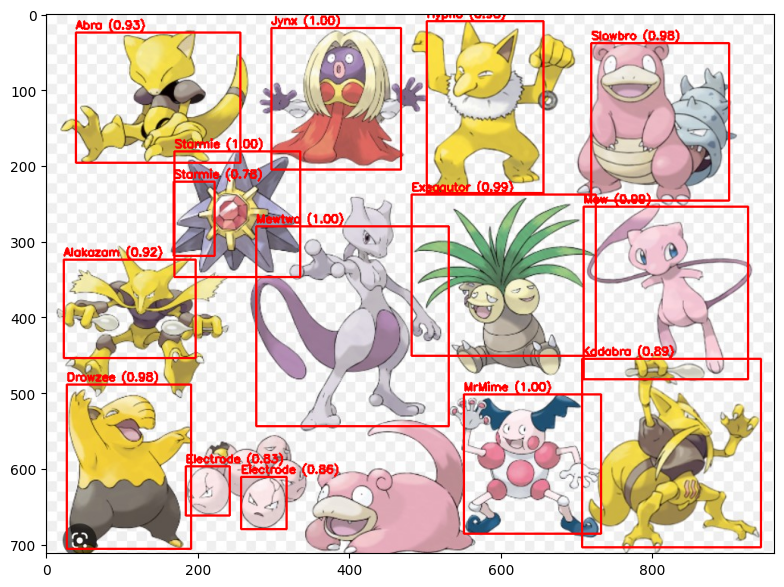

In [30]:
# Draw the bounding boxes
output_image = draw_boxes(input_image_path, nms_filtered_boxes, nms_filtered_labels, nms_filtered_confidences)
plt.figure(figsize=(12,7))
plt.imshow(output_image)

As we can see, the result of NMS is not as good as previous result, so we abandon this method.

The following part is our attempt to apply this algorithm on video inputs.

In [31]:
def draw_boxes_cv2(frame, boxes, labels, confidences):
    for box, label, conf in zip(boxes, labels, confidences):
        x1, y1, x2, y2 = box
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        text = f"{label} ({conf:.2f})"
        cv2.putText(frame, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return frame

In [32]:
def object_detection_frame(frame, model, threshold=0.0):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # image = Image.open(image_path).convert('RGB')
    image_tensor = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        detections = model(image_tensor)
    
    image_boxes = []
    for box, score in zip(detections[0]["boxes"], detections[0]["scores"]):
        if score > threshold:
            image_boxes.append(box)
    
    return image_boxes

Test with provided video clips, remember to modify the input and output file path.

In [44]:
# Set input and output video paths
input_video_path = "./test/videotest2.mp4"
output_video_path = "./test/testresults/videotest2_result.mp4"

# Open the input video
cap = cv2.VideoCapture(input_video_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"XVID")
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    
    bounding_boxes = object_detection_frame(frame, object_detection_model)
    bounding_boxes2 = object_detection_frame(frame, object_detection_model2)
    bounding_boxes3 = object_detection_frame(frame, object_detection_model3)
    bounding_boxes = bounding_boxes + bounding_boxes2 + bounding_boxes3

    boxes, labels, confidences = [], [], []
    for box in bounding_boxes:
        x1, y1, x2, y2 = map(int, box.tolist())
        cropped_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).crop((x1, y1, x2, y2))
        #cropped_image = Image.open(input_image_path).convert('RGB').crop((x1, y1, x2, y2))
        predicted_class, confidence = predictbox(cropped_image, model, class_names)
        boxes.append([x1, y1, x2, y2])
        labels.append(predicted_class)
        confidences.append(confidence)

    special_thresholds = {
        "Metapod": 0.98,
        "Voltorb": 0.98,
        "Kabuto": 0.8,
        "Eevee": 0.6,
        "Venusaur": 0.98,
        # Add more special classes here, e.g., "SpecialClass": 0.9,
    }

    filtered_boxes, filtered_labels, filtered_confidences = [], [], []
    for box, label, conf in zip(boxes, labels, confidences):
        threshold = special_thresholds.get(label, 0.92)  # Default threshold

        if conf > threshold:
            filtered_boxes.append(box)
            filtered_labels.append(label)
            filtered_confidences.append(conf)

    max_conf_per_class = {}
    for i, conf in enumerate(filtered_confidences):
        label = filtered_labels[i]
        if label not in max_conf_per_class or conf > max_conf_per_class[label][0]:
            max_conf_per_class[label] = (conf, i)

    # Extract the filtered boxes, labels, and confidences using the indices
    max_indices = [val[1] for val in max_conf_per_class.values()]
    max_boxes = [filtered_boxes[i] for i in max_indices]
    max_labels = [filtered_labels[i] for i in max_indices]
    max_confidences = [filtered_confidences[i] for i in max_indices]
    
    # Draw the bounding boxes on the frame
    frame_with_boxes = draw_boxes_cv2(frame, max_boxes, max_labels, max_confidences)

    # Write the frame to the output video
    out.write(frame_with_boxes)

    # Display the frame (optional)
    cv2.imshow("Frame", frame_with_boxes)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the input and output video objects
cap.release()
out.release()

# Close the display window (if used)
cv2.destroyAllWindows()